## Table of Contents:
1. [Problem Description](#problem-description)
2. [Getting the input data](#input-data)
3. [Construct PyPSA model](#pypsa-model)
4. [Procurement strategy: annualised matching](#annual-match)
5. [Procurement strategy: 24/7 CFE](#247-cfe)


In [1]:
import pypsa
import random
import pandas as pd
import matplotlib.pyplot as plt

## 1. Problem Description <a class="anchor" id="problem-description"></a>

In this example, we are going to build a super simple illustrative power model for Singapore (SGP) using PyPSA. 

This notebook will help you to:

1. Understand how to make PyPSA models.
2. Understand the components of the PyPSA framework.

Our super simple model for SGP is illustrated below. As we can see, we are imagining that SGP's power generation system is made up of a single fossil (gas) power plant and a solar farm. The outpot from these two plants is pooled in the local balancing zone and distributed to the whole country. Clearly, this is just an illustrative model and the real-world system is far more complex. However, these types of "lumped flow models" can be quite useful to a modeller/analyst when testing out scenarios and methodologies. 

<div>
<img src="../img/toy_model_sgp.png" width="500"/>
</div>


## 2. Get the input data <a class="anchor" id="input-data"></a>
For these demos, all of our input data is contained within a Microsoft Excel file (`data/system_inputs.xlsx`). As you will see in the excel, the input data is separated into three sections: 

1. **Forcing data:** Hourly resolution data that are fed _exogenously_ into the model and are the major driver in the optimisation.
2. **System data:** Parameters related to the power system (e.g., capacities, demands, locations etc.)
3. **Assumptions:** Assumed parameters related to technologies (e.g., efficiencies, costs etc.)

We can read the whole excel file into a single Python class as below.

In [2]:
class LoadExcel():

    def __init__(
            self, 
            path_to_file = '../data/system_inputs.xlsx',
            country_iso = None,
    ):
        
        from openpyxl import load_workbook

        sheetnames = load_workbook(filename = '../data/system_inputs.xlsx').sheetnames
        sheetnames = [i for i in sheetnames if '>' not in i]

        for sheet in sheetnames:
            # read data
            df = pd.read_excel(path_to_file, sheet_name=sheet)
        
            # snapshot as index
            if 'snapshot' in df.columns:
                df['snapshot'] = pd.to_datetime(df['snapshot'])
                df = df.set_index('snapshot')

                if country_iso is not None:
                    try:
                        df = df[country_iso]
                    except:
                        pass
            
            # filter regions
            if not country_iso:
                pass
            else:
                try:
                    df = df.loc[ df.iso.isin(country_iso) ].reset_index(drop=True)
                except:
                    pass

            setattr(self, sheet, df.copy())


# let's get our input data for a 48 hour (2-day) simulation
input_data = LoadExcel(country_iso=['SGP'])

<Axes: xlabel='snapshot'>

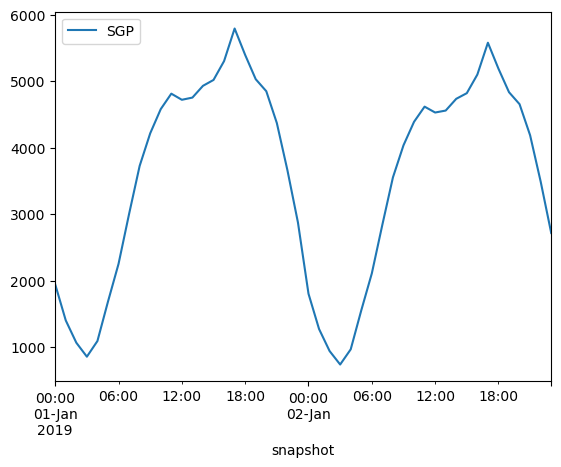

In [3]:
input_data.load_profile.iloc[0:48].plot()

In [4]:
import plotly.express as px

px.bar( 
    data_frame = input_data.generation,
    x = 'iso',
    y = 'capacity',
    color = 'variable',
    width=400, 
    height=400
)

In [5]:
input_data.buses

,country,iso,longitude,latitude
0,singapore,SGP,103.851959,1.29027


## 3. Construct the PyPSA model <a class="anchor" id="pypsa-model"></a>


In [6]:
input_data.solar

,capacity_factor
snapshot,
2019-01-01 00:00:00,0.119
2019-01-01 01:00:00,0.267
2019-01-01 02:00:00,0.387
2019-01-01 03:00:00,0.417
2019-01-01 04:00:00,0.423
...,...
2019-12-31 19:00:00,0.000
2019-12-31 20:00:00,0.000
2019-12-31 21:00:00,0.000


In [7]:
def construct_pypsa_model(
        country_iso, 
        timesteps, 
        add_industry_load = False,
        industry_load_pctg = 0.2,
        p_nom_extendable = True,
):

    # load data directly in model constructor
    input_data = LoadExcel(country_iso=country_iso)

    # initiate blank pypsa network
    network = pypsa.Network()

    # add input data
    network.input_data = input_data

    # define our hourly timesteps (referred to as snapshots)
    network.set_snapshots(input_data.load_profile.iloc[0:timesteps].index)

    # add buses
    for _, row in input_data.buses.iterrows():

        network.add(
            "Bus",  # PyPSA component
            row['iso'], # bus name
            x = row['longitude'], # longitude
            y = row['latitude'], # latitude
        )

    # setup energy carriers
    emissions_dict = input_data.technology_params[
        input_data.technology_params['Row Labels'].isin(input_data.generation.variable.unique().tolist())
        ].set_index('Row Labels')['CO2 intensity'].fillna(0).to_dict()
    
    network.madd(
        'Carrier', # PyPSA component
        input_data.generation.variable.unique().tolist(), # carriers
        co2_emissions=emissions_dict, # co2/mwh
        #nice_name=['Natural Gas', 'Solar PV'], # verbose names
        #color=['grey', 'yellow'], # colours for plotting
    )

    # define the demand curve
    for col in input_data.load_profile.columns:

        network.add(
                "Load", 
                col, 
                bus=col, 
                p_set=input_data.load_profile[col].iloc[0:timesteps],
            )
        
    # add industry load
    if add_industry_load:
        network.add(
            "Load", 
            col + "_industrial_load", 
            bus=col, 
            p_set=input_data.load_profile[col].mul(industry_load_pctg).iloc[0:timesteps],
        )

    # now let's add our generators
    for _, row in input_data.generation.iterrows():
        
        if row['variable'] in ['solar','wind']:
            
            if row['variable'] == 'solar':
                capacity_factor = input_data.solar.iloc[0:timesteps].capacity_factor
                
            else:
                capacity_factor = input_data.wind.iloc[0:timesteps].capacity_factor

            network.add(
                'Generator', # PyPSA component
                row['iso'] + '_' + row['variable'], # generator name
                bus = row['iso'], # balancing zone
                carrier = row['variable'],
                p_nom = row['capacity'] * 1e3, # starting capacity (GW -> MW)
                p_nom_extendable = p_nom_extendable, # let's allow the model to build more solar
                p_max_pu=capacity_factor, # here's where we feed in our solar profile
                marginal_cost = row['marginal_cost'],
                #capital_cost = row['capital_cost'],
                capital_cost = 0,
            )

        else:
            network.add(
                'Generator', # PyPSA component
                row['iso'] + '_' + row['variable'], # generator name
                bus = row['iso'], # balancing zone
                carrier = row['variable'],
                p_nom = row['capacity'] * 1e3, # starting capacity (GW -> MW)
                marginal_cost = row['marginal_cost'],
                #capital_cost = row['capital_cost'],
                capital_cost = 0,
                p_nom_extendable = p_nom_extendable, # can the model build more? let's say yes in this case
            )
    
    # finally, let's add storage units
    
    return network


INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.solvers:Log file at /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 336 primals, 720 duals
Objective: 8.40e+06
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
0 rows, 24 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-720); columns 0(-336); elements 0(-1008) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  8.4029048678e+06
HiGHS run time      :          0.00


<Axes: xlabel='snapshot'>

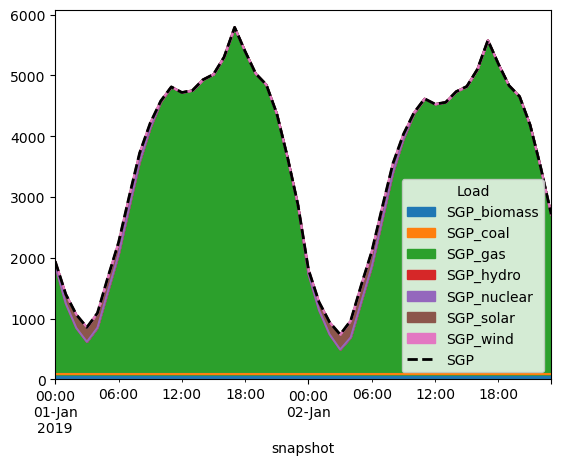

In [8]:
# let's run the model
sgp_model = construct_pypsa_model(country_iso=['SGP'], timesteps=48, p_nom_extendable=False)
sgp_model.optimize(solver_name='highs')


# let's look at the dispatch as a time series
f,ax = plt.subplots(nrows=1,ncols=1)
# dispatch by carrier
sgp_model.generators_t.p.plot.area(stacked=True,ax=ax)
# demand
sgp_model.loads_t.p.plot(color='black',linewidth=2,linestyle='--',ax=ax,label='Demand')

In [9]:
# total dispatch by carrier
sgp_model.statistics.dispatch()

component  carrier
Load       -         -170515.080827
Generator  biomass      3840.000000
           gas        162997.440827
           solar        3677.640000
dtype: float64

In [10]:
# total curtailment by carrier
sgp_model.statistics.curtailment()

component  carrier
Generator  biomass    0.000000e+00
           coal       0.000000e+00
           gas        0.000000e+00
           hydro      0.000000e+00
           nuclear    0.000000e+00
           solar      7.283063e-14
           wind       0.000000e+00
dtype: float64

In [11]:
# energy balance by carrier and loads (i.e. input vs output)
sgp_model.statistics.energy_balance()

component  carrier  bus_carrier
Load       -        AC            -170515.080827
Generator  biomass  AC               3840.000000
           coal     AC                  0.000000
           gas      AC             162997.440827
           hydro    AC                  0.000000
           nuclear  AC                  0.000000
           solar    AC               3677.640000
           wind     AC                  0.000000
dtype: float64

In [12]:
# capacity expansion
sgp_model.statistics.expanded_capacity()

component  carrier
Generator  biomass    0.0
           coal       0.0
           gas        0.0
           hydro      0.0
           nuclear    0.0
           solar      0.0
           wind       0.0
dtype: float64

## 4. Procurement strategy: annualised matching <a class="anchor" id="annual-match"></a>
Let's now explore the system level impacts of different procurement strategies. Before we do so, however, we need to run a model without any special procurement strategy by the industrial asset. We call this the baseline simulation.

In [13]:
timesteps = 24*31
industry_load_pctg = 0.01

baseline_model = \
    construct_pypsa_model( 
        country_iso=['SGP'], 
        timesteps=timesteps,
        p_nom_extendable=False,
        add_industry_load=True,
        industry_load_pctg=industry_load_pctg,
    )

# run model
baseline_model.optimize(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.03s
INFO:linopy.solvers:Log file at /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 5208 primals, 11160 duals
Objective: 1.33e+08
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
0 rows, 372 cols, 0 nonzeros
0 rows, 0 cols, 0 nonzeros
Presolve : Reductions: rows 0(-11160); columns 0(-5208); elements 0(-15624) - Reduced to empty
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Objective value     :  1.3319125151e+08
HiGHS run time      :          0.00


('ok', 'optimal')

### Annual matching constraint:
First, we explore the annualised matching constraint. The annual matching condition states that the total annual demand $D$ of the industrial asset $i$ should exceed the **additional** solar and wind generation ($g_{s}$ and $g_{w}$, respectively) procured from the grid, such that:

$$
  \sum_{t=1}^{T} { g_{s} + g_{w} } = D_{i} ~~~ \forall ~~ t \in T
$$

In [14]:
# now, let's create a second network to do the annualised matching
annual_matching = \
    construct_pypsa_model( 
        country_iso=['SGP'], 
        timesteps=timesteps,
        p_nom_extendable=False,
        add_industry_load=True,
        industry_load_pctg=industry_load_pctg,
    )

# now, let's add generators to represent new solar and wind installations
annual_matching.add(
    'Generator', # PyPSA component
    'SGP_solar_new', # generator name
    bus = 'SGP', # balancing zone
    carrier = 'solar',
    p_nom = 0,
    p_nom_extendable = True, # allow model to expand this asset
    p_max_pu = annual_matching.input_data.solar.iloc[0:timesteps].capacity_factor, # here's where we feed in our solar profile
    marginal_cost = annual_matching.input_data.generation.query( " variable == 'solar' ").marginal_cost.iloc[0],
    capital_cost = annual_matching.input_data.generation.query( " variable == 'solar' ").capital_cost.iloc[0] * 1e6,
)

annual_matching.add(
    'Generator', # PyPSA component
    'SGP_wind_new', # generator name
    bus = 'SGP', # balancing zone
    carrier = 'wind',
    p_nom = 0,
    p_nom_extendable = True, # allow model to expand this asset
    p_max_pu = annual_matching.input_data.wind.iloc[0:timesteps].capacity_factor, # here's where we feed in our solar profile
    marginal_cost = annual_matching.input_data.generation.query( " variable == 'wind' ").marginal_cost.iloc[0],
    capital_cost = annual_matching.input_data.generation.query( " variable == 'wind' ").capital_cost.iloc[0] * 1e6,
)

# we also want to make sure that the non-wind and -solar generation is the same as the brownfield network
# first, we want to fix the generation from all assets other than solar and wind to that from the baseline system. 
# This allows us to quantify the additional solar and wind we need to procure.

# fixed_generators = [ 
#     i for i in baseline_model.generators_t.p.columns if 
#     "coal" in i or 
#     #"gas" in i or 
#     "hydro" in i or 
#     "nuclear" in i or
#     "biomass" in i
# ]

# for col in fixed_generators:
#     annual_matching.generators_t['p_set'][col] = \
#         pd.DataFrame( 
#             baseline_model.generators_t.p[col],
#             index=baseline_model.generators_t.p.index,
#         )

# get total demand
total_industry_demand = baseline_model.loads_t.p_set['SGP_industrial_load'].sum()

# get total renewable generation
lp_model = annual_matching.optimize.create_model()

total_new_renewable_generation = lp_model.variables['Generator-p'].sel(Generator=['SGP_solar_new', 'SGP_wind_new']).sum()

# add constraint
lp_model.add_constraints(
    total_new_renewable_generation >= total_industry_demand,
)

annual_matching.optimize.solve_model(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.05s
INFO:linopy.solvers:Log file at /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/highs.log.
Status: unknown
Termination condition: unknown
Solution: 6698 primals, 14139 duals
Objective: 0.00e+00
Solver model: available
Solver message: not set



Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
1858 rows, 2975 cols, 6312 nonzeros
1858 rows, 2975 cols, 6312 nonzeros
Presolve : Reductions: rows 1858(-12281); columns 2975(-3723); elements 6312(-16379)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 745(1.49542e+06) 0s
Model   status      : Not Set
HiGHS run time      :          0.01


('unknown', 'unknown')

### Understanding the results:
We can see from the statistics and plots below that annually matching the industrial assets' demand with solar and wind energy entails building 1.3 GW of new solar capacity. This result was calculated for just one month (January) and assuming industrial demand is equivalent to 3% of national demand in Singapore.

In [15]:
# comparing capacity
annual_matching.statistics.expanded_capacity() - baseline_model.statistics.expanded_capacity()

component  carrier
Generator  biomass      -80.0
           coal           0.0
           gas       -10350.0
           hydro          0.0
           nuclear        0.0
           solar       -570.0
           wind           0.0
dtype: float64

In [16]:
annual_matching.generators.filter(regex='p_nom')

attribute,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_nom_opt
Generator,,,,,,
SGP_biomass,80.0,0.0,False,0.0,inf,0.0
SGP_coal,0.0,0.0,False,0.0,inf,0.0
SGP_gas,10350.0,0.0,False,0.0,inf,0.0
SGP_hydro,0.0,0.0,False,0.0,inf,0.0
SGP_nuclear,0.0,0.0,False,0.0,inf,0.0
SGP_solar,570.0,0.0,False,0.0,inf,0.0
SGP_wind,0.0,0.0,False,0.0,inf,0.0
SGP_solar_new,0.0,0.0,True,0.0,inf,0.0
SGP_wind_new,0.0,0.0,True,0.0,inf,0.0


In [17]:
# let's look at what the dispatch looks like

import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

figures = []
timesteps = 24*10

# baseline
def get_dispatch_results(model_run):

    df = model_run.generators_t.p.copy()

    return (
        df[df.columns[df.sum()>0]]
            .iloc[0:timesteps]
            .reset_index()
            .melt(id_vars='snapshot')
    )

df = get_dispatch_results(baseline_model)

figures.append(
    px.area(df, x='snapshot', y="value", color='Generator')
)

# annual matching
df = get_dispatch_results(annual_matching)

figures.append(
    px.area(df, x='snapshot', y="value", color='Generator')
)

# make subplots
fig = make_subplots(rows=len(figures), cols=1) 

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)
        
fig.show()

## 5. Procurement strategy: monthly matching <a class="anchor" id="annual-match"></a>
The next strategy we want to explore is based on monthly matching. This condition states that the total monthly demand $D_m$ of the industrial asset $i$ in each month $m$ of the year ($m \in M$) should exceed the **additional** solar and wind generation ($g_s$ and $g_w$), such that:

$$
  \sum_{t=1}^{T} { g_{s,m} + g_{w,m} } = D_{i,m} ~~~ \forall ~~ m \in M ~ \text{and} ~ t \in T
$$

## 5. Procurement strategy: 24/7 CFE <a class="anchor" id="247-cfe"></a>
Finally, we will explore the 24/7 carbon-free procurement strategy. This condition states that the total hourly monthly demand $D_t$ of the industrial asset $i$ should exceed the **additional** solar and wind generation ($g_s$ and $g_w$) in each hour, such that:

$$
  \sum_{t=1}^{T} { g_{s,t} + g_{w,t} } = D_{i,t} ~~~ \forall ~~ t \in T
$$

In [39]:
# create the network to do 24/7 matching
cfe = \
    construct_pypsa_model( 
        country_iso=['SGP'], 
        timesteps=timesteps,
        p_nom_extendable=False,
        add_industry_load=True,
        industry_load_pctg=industry_load_pctg,
    )

# now, let's add generators to represent new solar and wind installations
cfe.add(
    'Generator', # PyPSA component
    'SGP_solar_new', # generator name
    bus = 'SGP', # balancing zone
    carrier = 'solar',
    p_nom = 0,
    p_nom_extendable = True, # allow model to expand this asset
    p_max_pu = cfe.input_data.solar.iloc[0:timesteps].capacity_factor, # here's where we feed in our solar profile
    marginal_cost = cfe.input_data.generation.query( " variable == 'solar' ").marginal_cost.iloc[0],
    capital_cost = cfe.input_data.generation.query( " variable == 'solar' ").capital_cost.iloc[0] * 1e9,
)

cfe.add(
    'Generator', # PyPSA component
    'SGP_wind_new', # generator name
    bus = 'SGP', # balancing zone
    carrier = 'wind',
    p_nom = 0,
    p_nom_extendable = True, # allow model to expand this asset
    p_max_pu = cfe.input_data.wind.iloc[0:timesteps].capacity_factor, # here's where we feed in our solar profile
    marginal_cost = cfe.input_data.generation.query( " variable == 'wind' ").marginal_cost.iloc[0],
    capital_cost = cfe.input_data.generation.query( " variable == 'wind' ").capital_cost.iloc[0] * 1e9,
)

# get baseline renewable generation
baseline_renewable_generation = baseline_model.generators_t.p[['SGP_solar','SGP_wind']].sum().sum()

# get total renewable generation
lp_model = cfe.optimize.create_model()

hourly_new_renewable_generation = \
    lp_model.variables['Generator-p'].sel(Generator=['SGP_solar_new']) + \
        lp_model.variables['Generator-p'].sel(Generator=['SGP_wind_new'])

# add constraint
lp_model.add_constraints(
    hourly_new_renewable_generation >= cfe.loads_t.p_set['SGP_industrial_load'],
)

cfe.optimize.solve_model(solver_name='highs')

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.solvers:Log file at /private/var/folders/jj/phtp57h948z6wfc9fbrdq9fr0000gp/T/highs.log.
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2162 primals, 4802 duals
Objective: 1.68e+15
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, con0 were not assigned to the network.


Running HiGHS 1.5.3 [date: 2023-05-16, git hash: 594fa5a9d]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
714 rows, 959 cols, 1905 nonzeros
710 rows, 954 cols, 1894 nonzeros
Presolve : Reductions: rows 710(-4092); columns 954(-1208); elements 1894(-5425)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     1.9383639625e+00 Pr: 478(334649) 0s
        601     1.6797435158e+15 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 601
Objective value     :  1.6797435158e+15
HiGHS run time      :          0.01


('ok', 'optimal')

In [40]:
# let's look at what the dispatch looks like

import plotly.express as px
from plotly.offline import plot
from plotly.subplots import make_subplots

figures = []
timesteps_to_visualise = 24*10

# baseline
def get_dispatch_results(model_run):

    df = model_run.generators_t.p.copy()

    return (
        df[df.columns[df.sum()>0]]
            .iloc[0:timesteps_to_visualise]
            .reset_index()
            .melt(id_vars='snapshot')
    )

df = get_dispatch_results(baseline_model)

figures.append(
    px.area(df, x='snapshot', y="value", color='Generator')
)

# annual matching
df = get_dispatch_results(cfe)

figures.append(
    px.area(df, x='snapshot', y="value", color='Generator')
)

# make subplots
fig = make_subplots(rows=len(figures), cols=1) 

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        fig.append_trace(figure["data"][trace], row=i+1, col=1)
        
fig.show()

In [32]:
# comparing capacity
cfe.statistics.expanded_capacity() - baseline_model.statistics.expanded_capacity()

component  carrier
Generator  biomass       0.000000
           coal          0.000000
           gas           0.000000
           hydro         0.000000
           nuclear       0.000000
           solar       247.927609
           wind       3128.959348
dtype: float64

### Understanding the result:
Here, we can see that 24/7 CFE procurement results in significantly larger quantities of renewable installations. Onshore wind installations are expanded by ~3.1 GW to match the industrial demand hour-by-hour. Let's plot the dispatch for the industrial load. 

<Axes: xlabel='snapshot'>

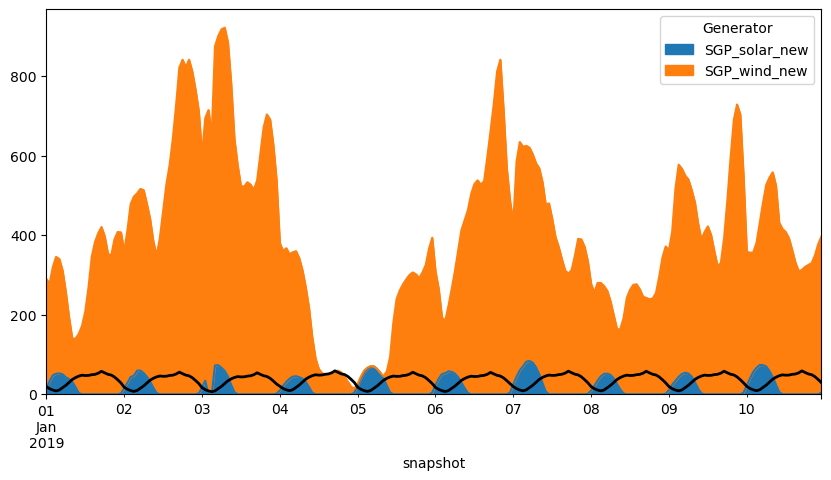

In [43]:
dispatch = (
    cfe
    .generators_t
    .p
    .filter(regex='new')
    .assign(industry_load = cfe.loads_t.p['SGP_industrial_load'])
)

f,ax = plt.subplots(figsize=(10,5))

dispatch.drop('industry_load', axis=1).plot.area(stacked=True, ax=ax)

dispatch['industry_load'].plot.line(color='black', linewidth=2, ax=ax)

In [23]:
cfe.statistics.curtailment()

component  carrier
Generator  biomass       0.000000
           coal          0.000000
           gas           0.000000
           hydro         0.000000
           nuclear       0.000000
           solar      4892.829062
           wind       3495.870587
dtype: float64